# Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import os
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Предобработка данных

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/ВКР/chest_ct_scan/'

In [ ]:
classes = os.listdir(data_path)

In [ ]:
def plot_class(path):
    plt.figure(figsize=(12,12))
    title = path.split('/')[-1]
    for i in range(1,5):
        plt.subplot(1,4,i)
        plt.tight_layout()
        rand_img = plt.imread(path +'/'+ random.choice(sorted(os.listdir(path))))
        plt.imshow(rand_img)
        plt.title(title, fontsize=15, color='blue')
        plt.xticks([])
        plt.yticks([])

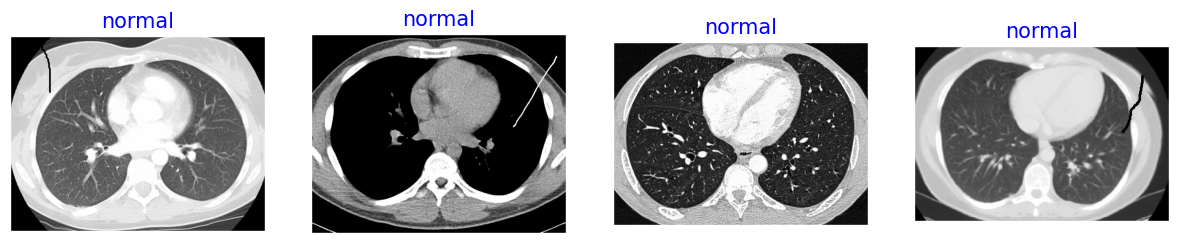

In [ ]:
plot_class(data_path+classes[0])

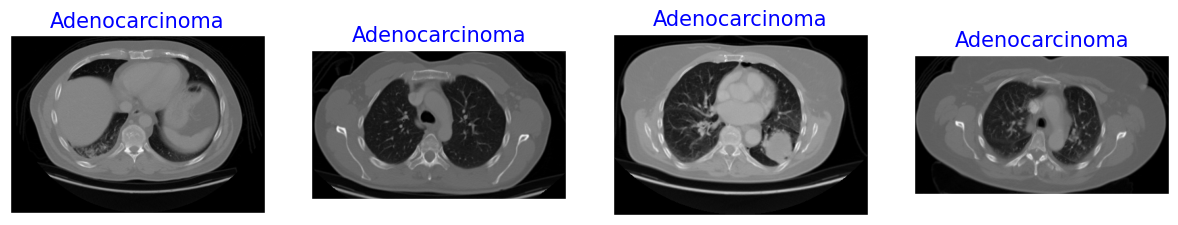

In [ ]:
plot_class(data_path+classes[1])

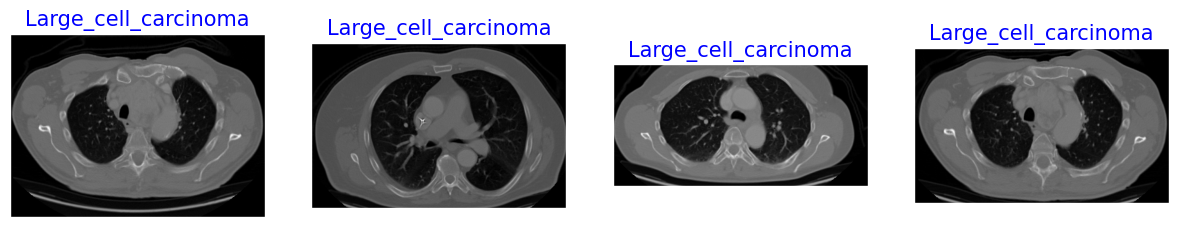

In [ ]:
plot_class(data_path+classes[2])

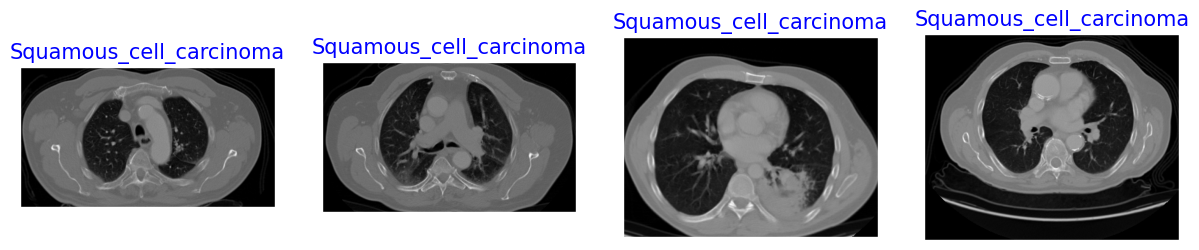

In [ ]:
plot_class(data_path+classes[3])

In [ ]:
def main(train_data_path):
    
    for dirs in [train_data_path]:

        filepaths = []
        labels = []
        classes_list = sorted(os.listdir(dirs))

        filepaths,labels = get_fileList(classes_list, dirs, filepaths, labels)
        
        train_df = obtain_train_df(filepaths, labels)
        
            
    return train_df



def get_fileList(classes_list, dirs, filepaths, labels):

    for s_class in classes_list:
        
        label = s_class
        classpath = os.path.join(dirs, s_class)
        flist = sorted(os.listdir(classpath))
        
        store_image_names_and_its_labels(flist, classpath, filepaths, labels, label)
        
    return filepaths, labels


def store_image_names_and_its_labels(flist, classpath, filepaths, labels, label):
    
    for file in flist:
        file_path = os.path.join(classpath, file)
        filepaths.append(file_path)
        labels.append(label)



def obtain_train_df(filepaths, labels):

    train_df =pd.DataFrame({
        'image_path' : filepaths,
        'label' : labels
    })
    return train_df

In [ ]:
data_df = main(data_path)

In [ ]:
data_df.head()

,image_path,label
0,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,Adenocarcinoma
1,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,Adenocarcinoma
2,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,Adenocarcinoma
3,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,Adenocarcinoma
4,/content/drive/MyDrive/Colab Notebooks/ВКР/che...,Adenocarcinoma


In [ ]:
num_classes = len(data_df['label'].unique())
print(f"We have {num_classes} classes")
print(f"We have {data_df.shape[0]} images")

We have 4 classes
We have 900 images


In [ ]:
data_df['label'].value_counts()

Adenocarcinoma             326
Squamous_cell_carcinoma    252
Large_cell_carcinoma       163
normal                     159
Name: label, dtype: int64

In [ ]:
def count_plot(x, title, xlabel, ylabel, width, length, order = None, rotation=False, palette='winter'):
    plt.figure(figsize=(width,length))
    sns.countplot(x = x, palette=palette, order = order)
    plt.title(title, fontsize=25)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=20)
    plt.ylabel(ylabel, fontsize=20)
    plt.show()

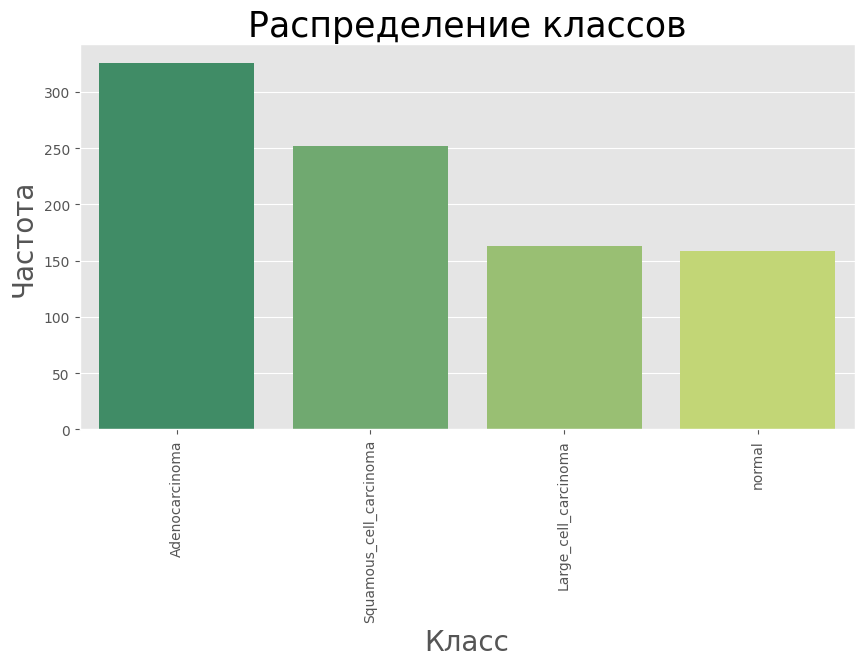

In [ ]:
x = data_df['label']
order = x.value_counts().index
count_plot(x, "Распределение классов", "Класс", 'Частота', 10,5, rotation = True, order=order, palette='summer')

In [ ]:
def define_paths(dir):
    filepaths = []
    labels = []

    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            fold = str(fold).replace('C+', '')
            labels.append(fold[:-3])

    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
def tr_ts_data(tr_dir, ts_dir):
    
    files, classes = define_paths(tr_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, valid_df = train_test_split(df, train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    files, classes = define_paths(tr_dir)
    test_df = define_df(files, classes)
    return train_df, valid_df, test_df

def full_data(data_dir):

    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

def tr_val_ts_data(tr_dir, val_dir, ts_dir):

    files, classes = define_paths(tr_dir)
    train_df = define_df(files, classes)

    files, classes = define_paths(val_dir)
    valid_df = define_df(files, classes)

    files, classes = define_paths(ts_dir)
    test_df = define_df(files, classes)

    return train_df, valid_df, test_df

In [ ]:
def split_data(tr_dir, val_dir=None, ts_dir=None):

    if val_dir == '' and ts_dir == '':
        train_df, valid_df, test_df = full_data(tr_dir)
        return train_df, valid_df, test_df

    elif val_dir == '' and ts_dir != '':
        train_df, valid_df, test_df = tr_ts_data(tr_dir, ts_dir)
        return train_df, valid_df, test_df

    elif val_dir != '' and ts_dir != '':
        train_df, valid_df, test_df = tr_val_ts_data(tr_dir, val_dir, ts_dir)
        return train_df, valid_df, test_df

In [ ]:
def create_model_data (train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, 
                                horizontal_flip= True)
    
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, 
                                           x_col= 'filepaths', 
                                           y_col= 'labels', 
                                           target_size= img_size, 
                                           class_mode= 'categorical',
                                           color_mode= color, 
                                           shuffle= True, 
                                           batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, 
                                           x_col= 'filepaths', 
                                           y_col= 'labels', 
                                           target_size= img_size, 
                                           class_mode= 'categorical',
                                           color_mode= color, 
                                           shuffle= True, 
                                           batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe( test_df, 
                                          x_col= 'filepaths', 
                                          y_col= 'labels', 
                                          target_size= img_size, 
                                          class_mode= 'categorical',
                                          color_mode= color, 
                                          shuffle= False, 
                                          batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [ ]:
def show_images(gen):

    g_dict = gen.class_indices
    classes = list(g_dict.keys())
    images, labels = next(gen)

    length = len(labels) 
    sample = min(length, 25)  

    plt.figure(figsize= (10, 10))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()
    


In [ ]:
def plot_label_count(df, plot_title):

    vcounts = df['labels'].value_counts()
    labels = vcounts.keys().tolist()
    values = vcounts.tolist()
    lcount = len(labels)

    if lcount > 55:
        print('The number of labels is > 55, no plot will be produced')

    else:
        plot_labels(lcount, labels, values, plot_title)

def plot_labels(lcount, labels, values, plot_title):
    width = lcount * 4
    width = np.min([width, 20])

    plt.figure(figsize= (width, 5))

    form = {'family': 'serif', 'color': 'blue', 'size': 25}
    sns.barplot(x=labels, y=values)
    plt.title(f'Images per Label in {plot_title} data', fontsize= 24, color= 'blue')
    plt.xticks(rotation= 90, fontsize= 18)
    plt.yticks(fontsize= 18)
    plt.xlabel('CLASS', fontdict= form)
    yaxis_label = 'IMAGE COUNT'
    plt.ylabel(yaxis_label, fontdict= form)

    rotation = 'vertical' if lcount >= 8 else 'horizontal'
    for i in range(lcount):
        plt.text(i, values[i] / 2, str(values[i]), fontsize= 12,
                rotation= rotation, color= 'yellow', ha= 'center')

    plt.show()

In [ ]:
train_dir = data_path
valid_dir = input('Enter validation data directory (if no valid dir press Enter): ')
test_dir = input('Enter test data directory (if no test dir press Enter): ')

train_df, valid_df, test_df = split_data(train_dir, valid_dir, test_dir)

batch_size = 32
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

Enter validation data directory (if no valid dir press Enter): 
Enter test data directory (if no test dir press Enter): 
Found 720 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.


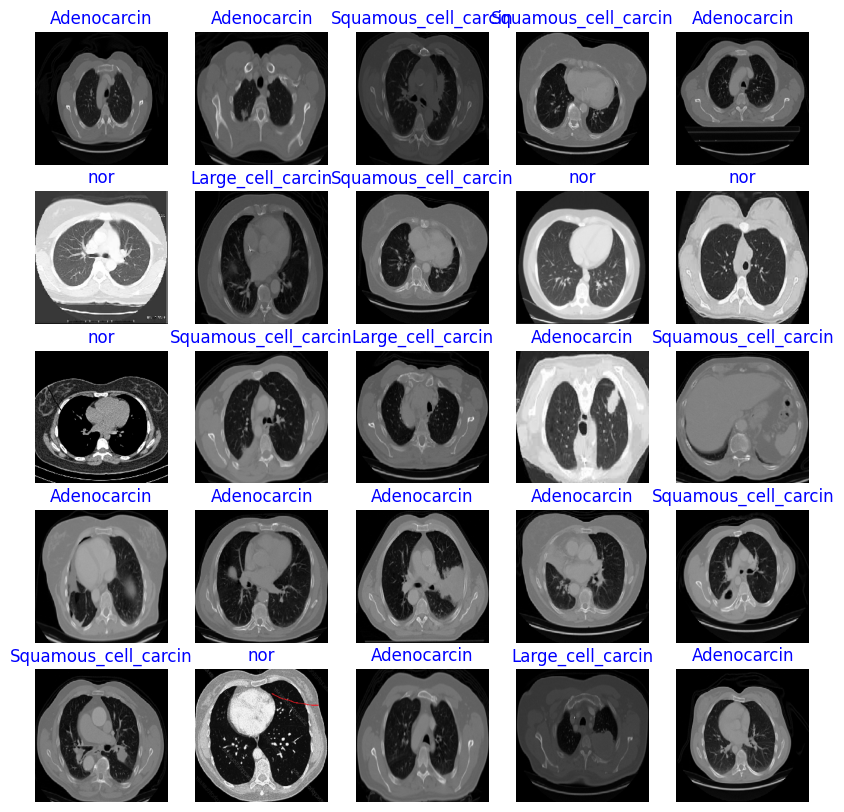

In [ ]:
show_images(train_gen)

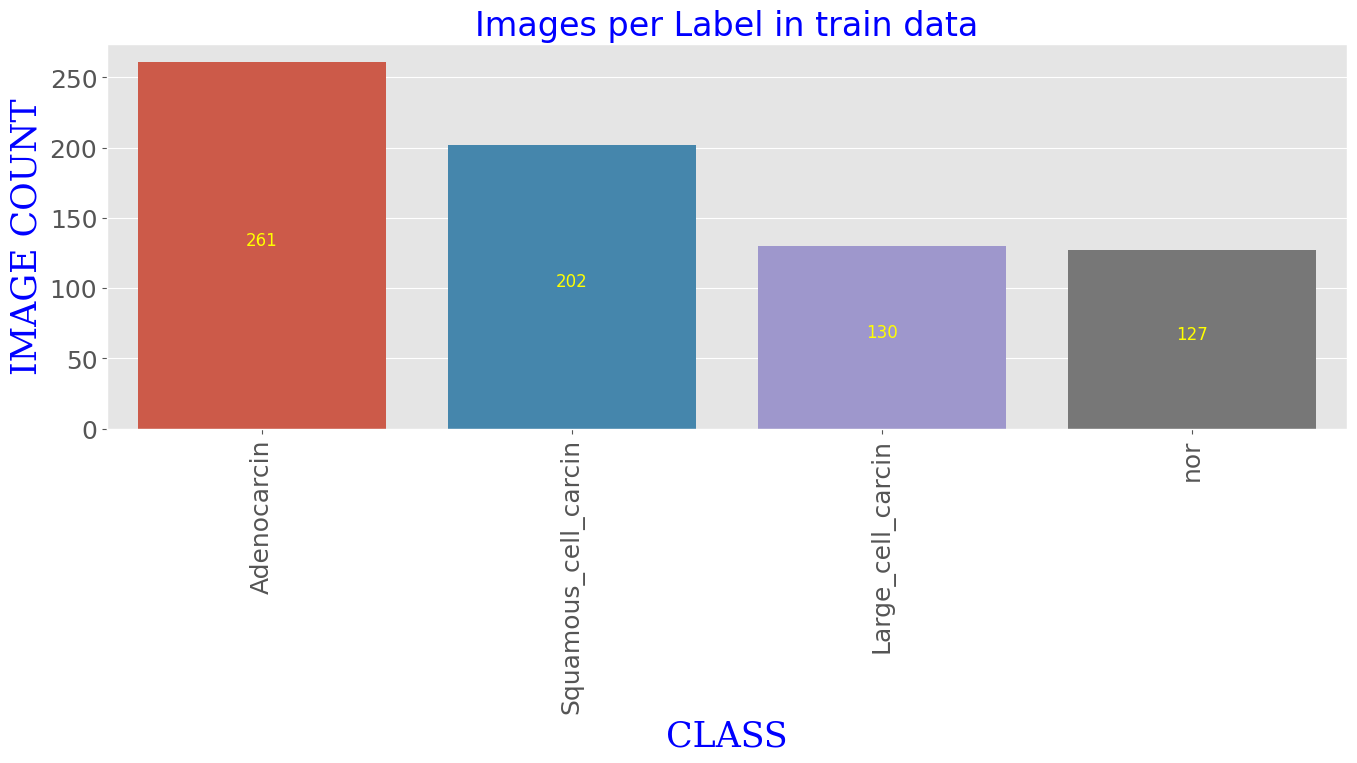

In [ ]:
plot_label_count(train_df, 'train')

# Обучение моделей

In [ ]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (15, 6))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 100, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 100, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

## Модель EfficientNet

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

115263384/115263384 [==============================] - 1s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 29,047,291
Trainable params: 28,870,452
Non-trainable params: 176,839
______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/scan_EfficientNetB5_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 9.2103 - accuracy: 0.5667
Epoch 1: val_loss improved from inf to 12.14843, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_EfficientNetB5_model_weights.h5
23/23 [==============================] - 138s 1s/step - loss: 9.2103 - accuracy: 0.5667 - val_loss: 12.1484 - val_accuracy: 0.5000
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 7.8148 - accuracy: 0.8556
Epoch 2: val_loss improved from 12.14843 to 9.81144, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_EfficientNetB5_model_weights.h5
23/23 [==============================] - 23s 997ms/step - loss: 7.8148 - accuracy: 0.8556 - val_loss: 9.8114 - val_accuracy: 0.5778
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 7.0904 - accuracy: 0.9250
Epoch 3: val_loss improved from 9.81144 to 7.72662, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_EfficientNetB5_model_weights.h5
23/23 [======

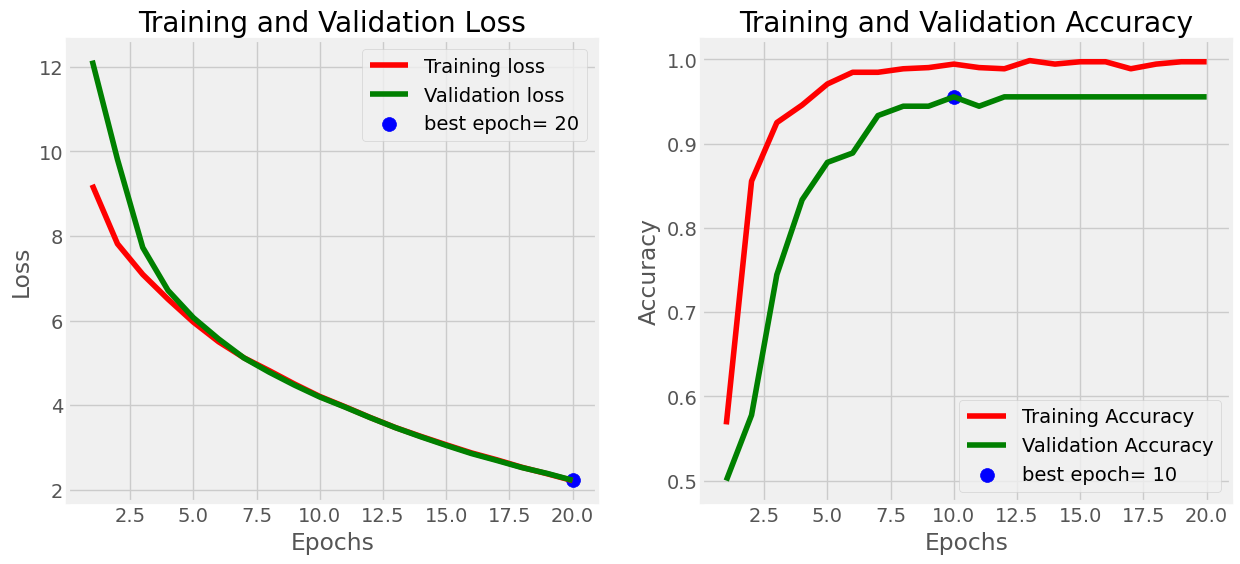

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 2s 269ms/step - loss: 2.2101 - accuracy: 0.9778
Train Loss:  2.121016502380371
Train Accuracy:  1.0
--------------------
Validation Loss:  2.258655071258545
Validation Accuracy:  0.9375
--------------------
Test Loss:  2.210057258605957
Test Accuracy:  0.9777777791023254


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

2/2 [==============================] - 6s 415ms/step


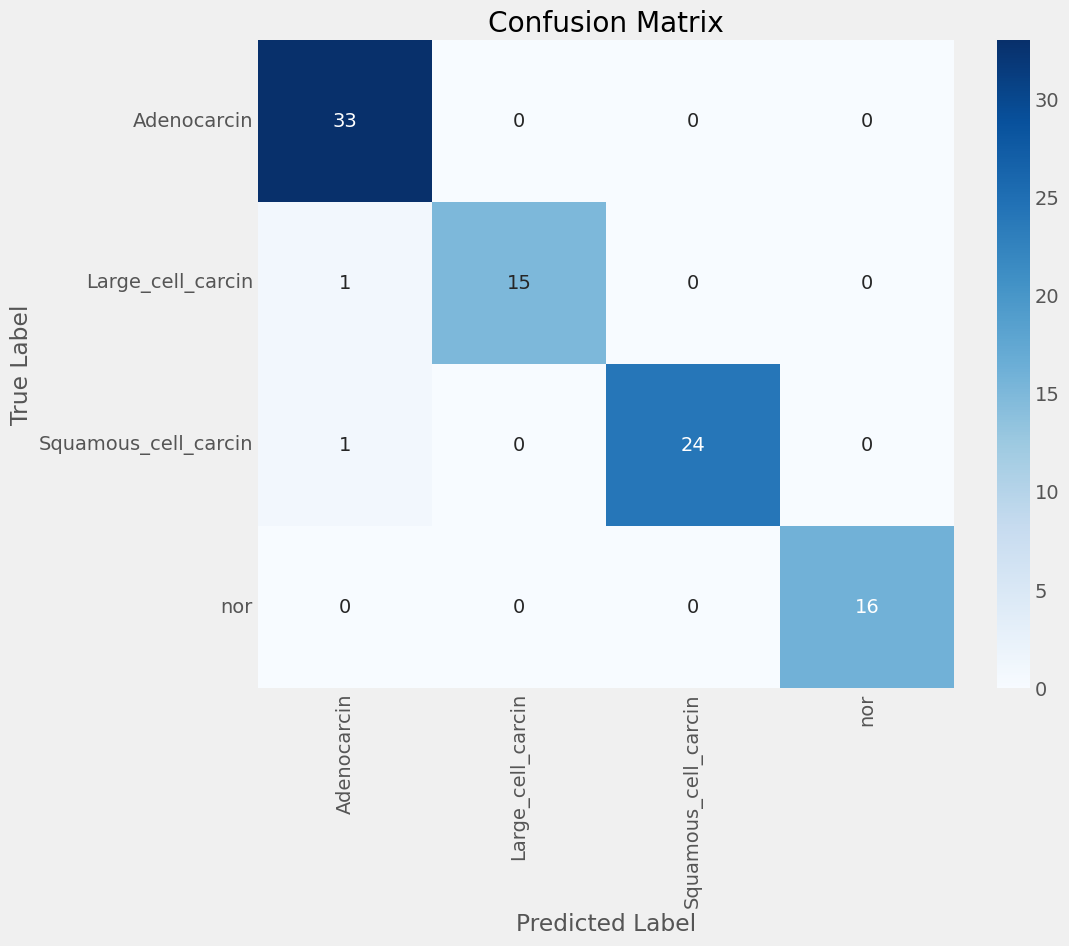

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                      precision    recall  f1-score   support

         Adenocarcin       0.94      1.00      0.97        33
   Large_cell_carcin       1.00      0.94      0.97        16
Squamous_cell_carcin       1.00      0.96      0.98        25
                 nor       1.00      1.00      1.00        16

            accuracy                           0.98        90
           macro avg       0.99      0.97      0.98        90
        weighted avg       0.98      0.98      0.98        90



## Модель ConvNeXt

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.convnext.ConvNeXtTiny(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

111650432/111650432 [==============================] - 1s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convnext_tiny (Functional)  (None, 768)               27820128  
                                                                 
 batch_normalization_1 (Batc  (None, 768)              3072      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               196864    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 28,021,092
Trainable params: 28,019,556
Non-trainable params: 1,536
______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/scan_ConvNext_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 7.9877 - accuracy: 0.4861
Epoch 1: val_loss improved from inf to 7.87108, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_ConvNext_model_weights.h5
23/23 [==============================] - 85s 2s/step - loss: 7.9877 - accuracy: 0.4861 - val_loss: 7.8711 - val_accuracy: 0.4222
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 7.0802 - accuracy: 0.6111
Epoch 2: val_loss improved from 7.87108 to 7.09450, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_ConvNext_model_weights.h5
23/23 [==============================] - 18s 776ms/step - loss: 7.0802 - accuracy: 0.6111 - val_loss: 7.0945 - val_accuracy: 0.4556
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 6.3751 - accuracy: 0.7125
Epoch 3: val_loss improved from 7.09450 to 6.73801, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_ConvNext_model_weights.h5
23/23 [============================

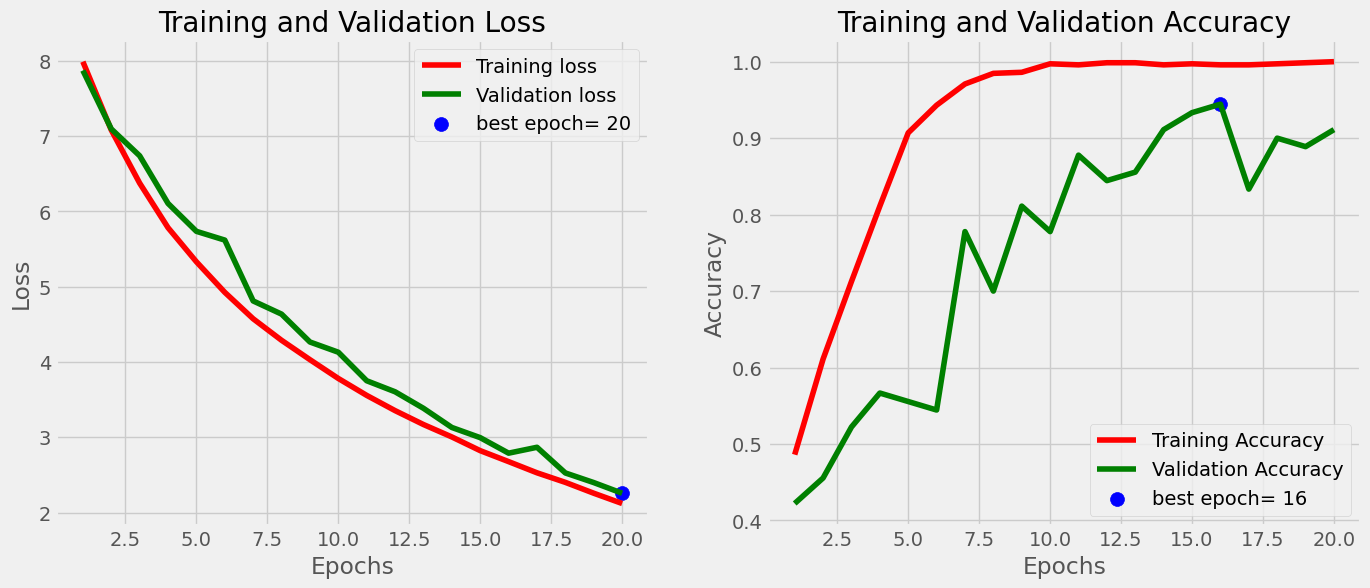

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 4s 325ms/step - loss: 2.1588 - accuracy: 0.9556
Train Loss:  2.0428338050842285
Train Accuracy:  1.0
--------------------
Validation Loss:  2.3338027000427246
Validation Accuracy:  0.875
--------------------
Test Loss:  2.158841371536255
Test Accuracy:  0.9555555582046509


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

2/2 [==============================] - 4s 360ms/step


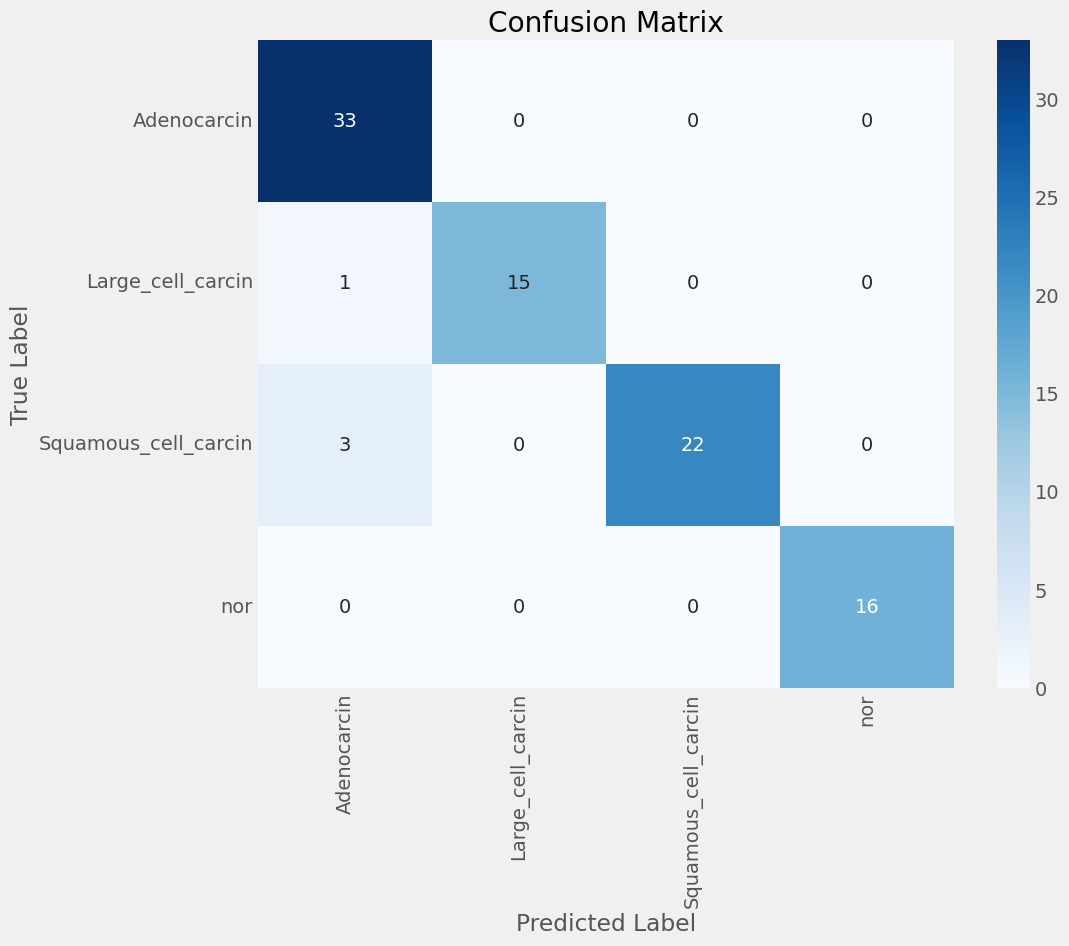

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                      precision    recall  f1-score   support

         Adenocarcin       0.89      1.00      0.94        33
   Large_cell_carcin       1.00      0.94      0.97        16
Squamous_cell_carcin       1.00      0.88      0.94        25
                 nor       1.00      1.00      1.00        16

            accuracy                           0.96        90
           macro avg       0.97      0.95      0.96        90
        weighted avg       0.96      0.96      0.96        90



## Модель Xception

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.xception.Xception(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 batch_normalization_6 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 21,395,244
Trainable params: 21,336,620
Non-trainable params: 58,624
_____________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/scan_Xception_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 9.5196 - accuracy: 0.5292
Epoch 1: val_loss improved from inf to 17.28948, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_Xception_model_weights.h5
23/23 [==============================] - 58s 1s/step - loss: 9.5196 - accuracy: 0.5292 - val_loss: 17.2895 - val_accuracy: 0.1778
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 8.0359 - accuracy: 0.8083
Epoch 2: val_loss improved from 17.28948 to 11.56194, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_Xception_model_weights.h5
23/23 [==============================] - 14s 585ms/step - loss: 8.0359 - accuracy: 0.8083 - val_loss: 11.5619 - val_accuracy: 0.1889
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 7.0605 - accuracy: 0.9319
Epoch 3: val_loss improved from 11.56194 to 8.61863, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_Xception_model_weights.h5
23/23 [======================

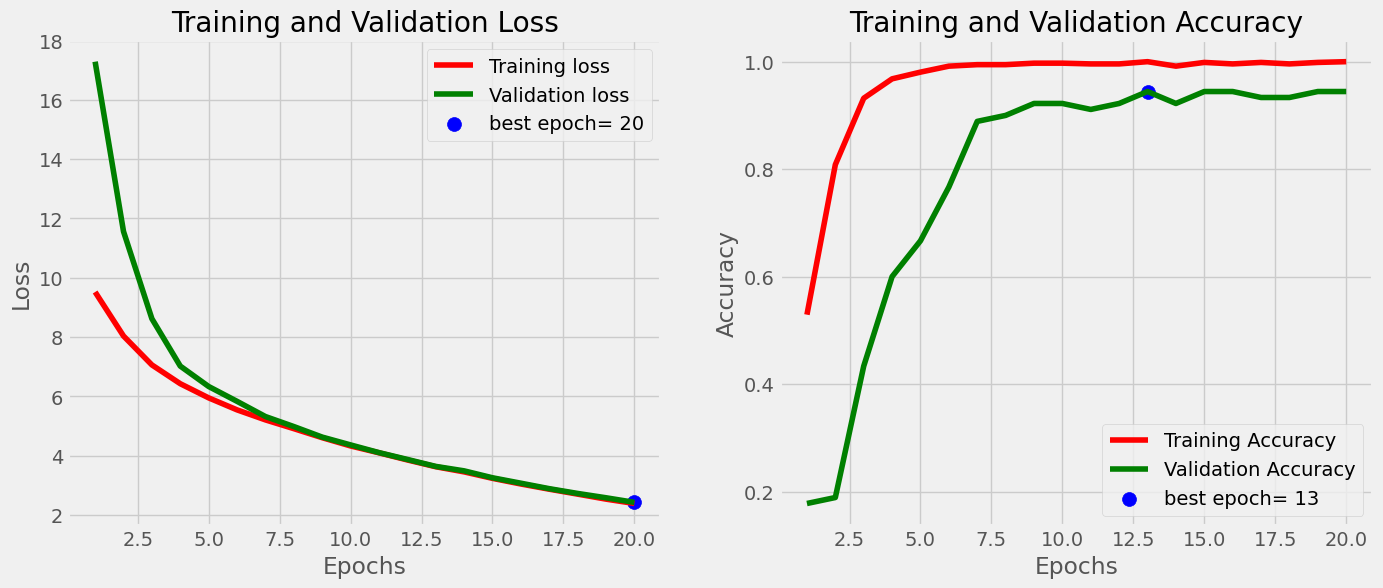

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 3s 176ms/step - loss: 2.3548 - accuracy: 0.9778
Train Loss:  2.2896904945373535
Train Accuracy:  1.0
--------------------
Validation Loss:  2.443202495574951
Validation Accuracy:  0.9375
--------------------
Test Loss:  2.354773998260498
Test Accuracy:  0.9777777791023254


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

2/2 [==============================] - 1s 258ms/step


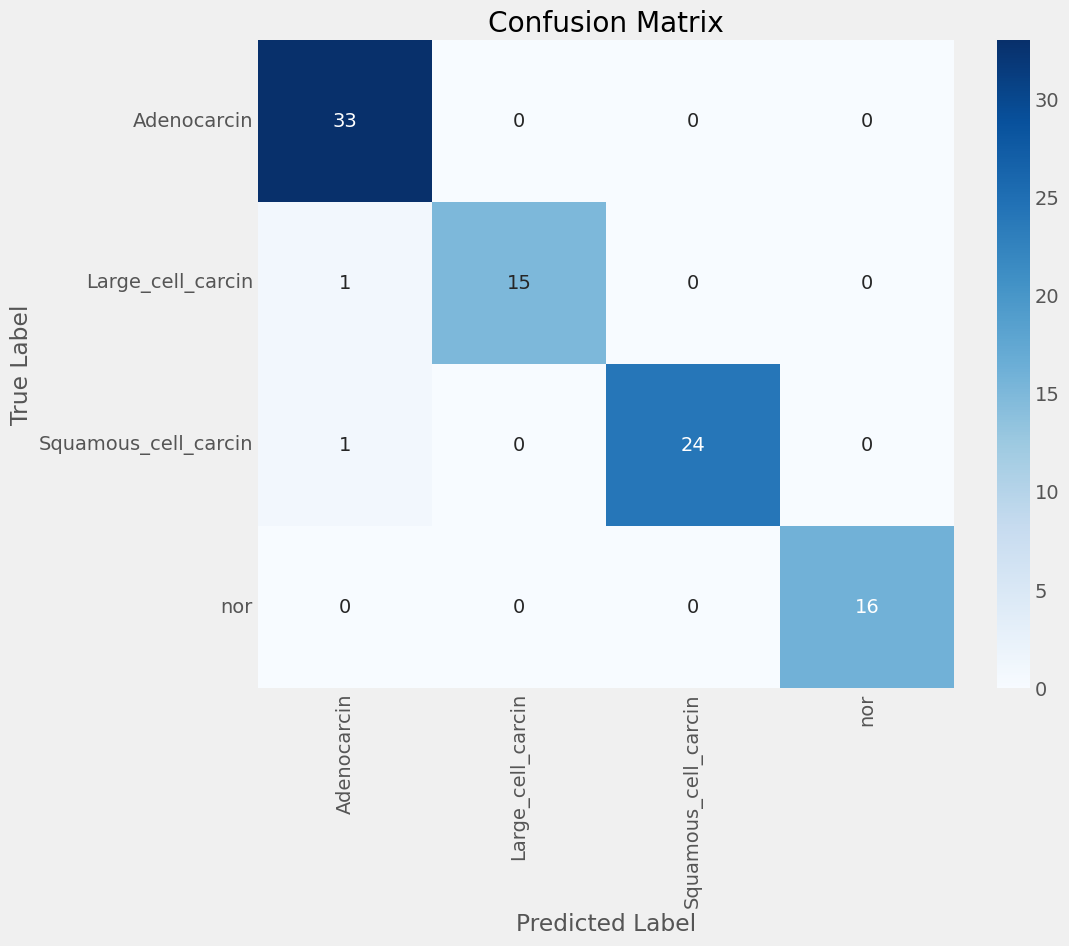

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                      precision    recall  f1-score   support

         Adenocarcin       0.94      1.00      0.97        33
   Large_cell_carcin       1.00      0.94      0.97        16
Squamous_cell_carcin       1.00      0.96      0.98        25
                 nor       1.00      1.00      1.00        16

            accuracy                           0.98        90
           macro avg       0.99      0.97      0.98        90
        weighted avg       0.98      0.98      0.98        90



## Модель NasNet

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.nasnet.NASNetMobile(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

19993432/19993432 [==============================] - 0s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 1056)              4269716   
                                                                 
 batch_normalization_7 (Batc  (None, 1056)             4224      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)               270592    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 4,545,560
Trainable params: 4,506,710
Non-trainable params: 38,850
_______________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/scan_NasNet_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 8.3736 - accuracy: 0.5431
Epoch 1: val_loss improved from inf to 12.62413, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_NasNet_model_weights.h5
23/23 [==============================] - 151s 685ms/step - loss: 8.3736 - accuracy: 0.5431 - val_loss: 12.6241 - val_accuracy: 0.1667
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 7.3306 - accuracy: 0.7514
Epoch 2: val_loss improved from 12.62413 to 9.73046, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_NasNet_model_weights.h5
23/23 [==============================] - 8s 330ms/step - loss: 7.3306 - accuracy: 0.7514 - val_loss: 9.7305 - val_accuracy: 0.2111
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 6.5671 - accuracy: 0.8806
Epoch 3: val_loss improved from 9.73046 to 8.53310, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_NasNet_model_weights.h5
23/23 [============================

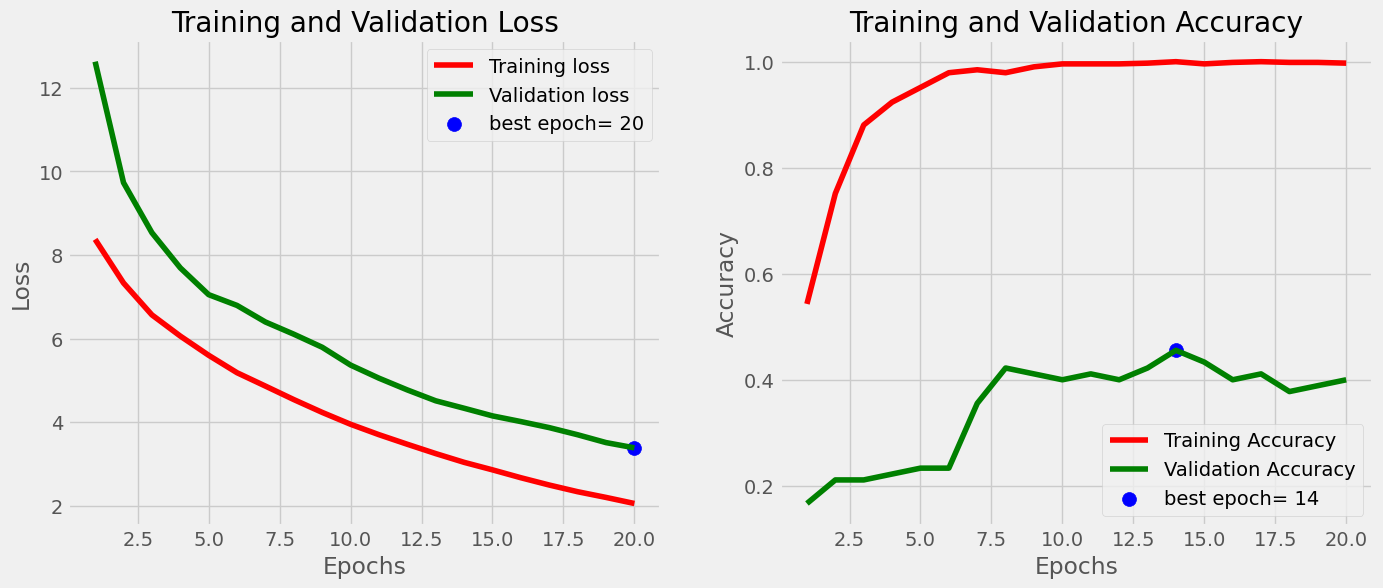

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 1s 94ms/step - loss: 3.4415 - accuracy: 0.3889
Train Loss:  3.4305548667907715
Train Accuracy:  0.328125
--------------------
Validation Loss:  3.325892925262451
Validation Accuracy:  0.40625
--------------------
Test Loss:  3.441544532775879
Test Accuracy:  0.3888888955116272


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

2/2 [==============================] - 5s 434ms/step


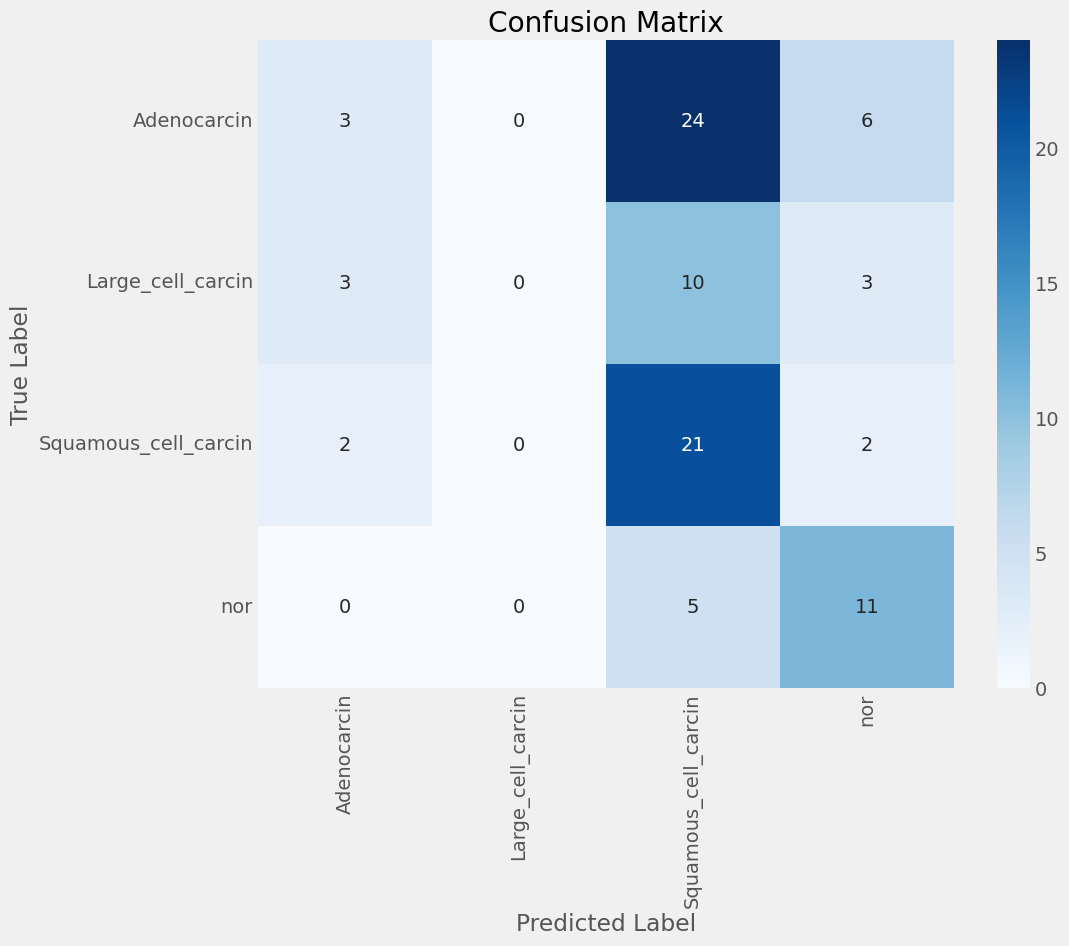

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                      precision    recall  f1-score   support

         Adenocarcin       0.38      0.09      0.15        33
   Large_cell_carcin       0.00      0.00      0.00        16
Squamous_cell_carcin       0.35      0.84      0.49        25
                 nor       0.50      0.69      0.58        16

            accuracy                           0.39        90
           macro avg       0.31      0.40      0.30        90
        weighted avg       0.32      0.39      0.29        90



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Модель InceptionResNetV2

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))


base_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(include_top= False, 
                                                               weights= "imagenet", 
                                                               input_shape= img_shape, 
                                                               pooling= 'max')

219055592/219055592 [==============================] - 1s 0us/step


In [ ]:
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, 
          kernel_regularizer= regularizers.l2(l= 0.016), 
          activity_regularizer= regularizers.l1(0.006),
          bias_regularizer= regularizers.l1(0.006), 
          activation= 'relu'),
    
    Dropout(rate= 0.45, 
            seed= 123),
    
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 1536)             54336736  
 onal)                                                           
                                                                 
 batch_normalization_211 (Ba  (None, 1536)             6144      
 tchNormalization)                                               
                                                                 
 dense_8 (Dense)             (None, 256)               393472    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 54,737,380
Trainable params: 54,673,764


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', 
                           patience=10,
                           verbose=1)

checkpoint = ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/ВКР/scan_InceptionResNetV2_model_weights.h5', 
                             monitor='val_loss', 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min', 
                             verbose=1)


history = model.fit(x= train_gen, 
                    epochs= 20, 
                    callbacks=[early_stop, checkpoint],
                    validation_data= valid_gen)

Epoch 1/20
23/23 [==============================] - ETA: 0s - loss: 9.1598 - accuracy: 0.5153
Epoch 1: val_loss improved from inf to 95.48756, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_InceptionResNetV2_model_weights.h5
23/23 [==============================] - 120s 1s/step - loss: 9.1598 - accuracy: 0.5153 - val_loss: 95.4876 - val_accuracy: 0.3556
Epoch 2/20
23/23 [==============================] - ETA: 0s - loss: 7.7547 - accuracy: 0.7292
Epoch 2: val_loss improved from 95.48756 to 10.05163, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_InceptionResNetV2_model_weights.h5
23/23 [==============================] - 15s 665ms/step - loss: 7.7547 - accuracy: 0.7292 - val_loss: 10.0516 - val_accuracy: 0.4444
Epoch 3/20
23/23 [==============================] - ETA: 0s - loss: 7.1149 - accuracy: 0.8667
Epoch 3: val_loss improved from 10.05163 to 8.47464, saving model to /content/drive/MyDrive/Colab Notebooks/ВКР/scan_InceptionResNetV2_model_weights.h5
2

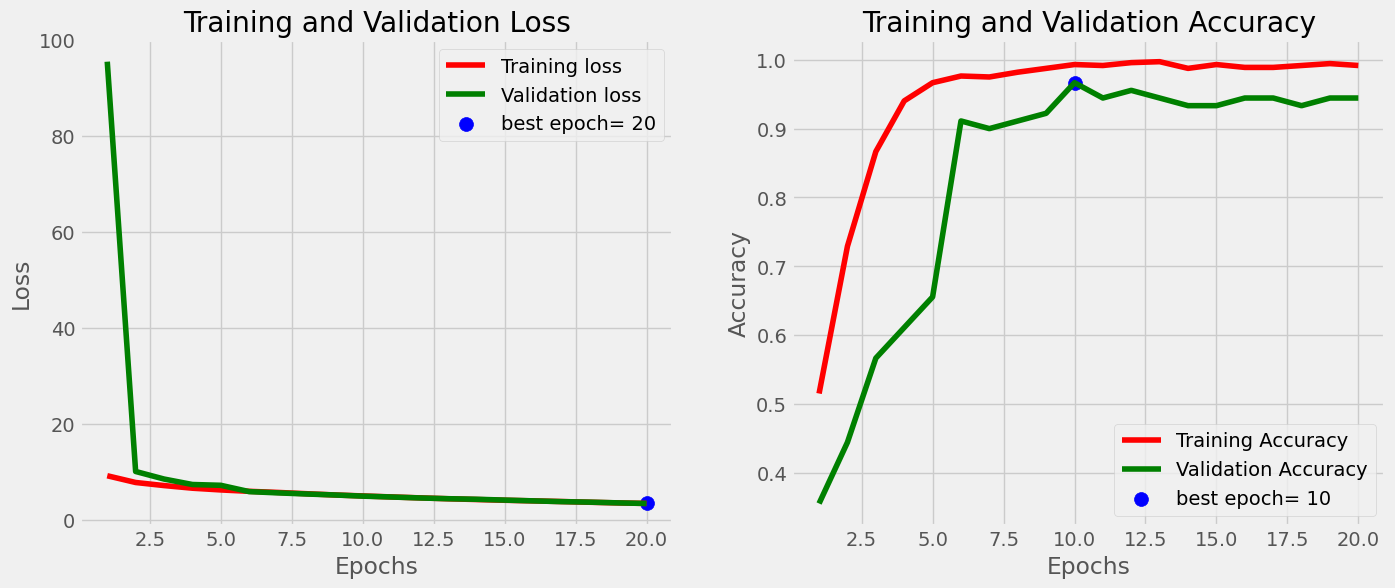

In [ ]:
plot_training(history)

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

2/2 [==============================] - 3s 225ms/step - loss: 3.6928 - accuracy: 0.9667
Train Loss:  3.6187193393707275
Train Accuracy:  1.0
--------------------
Validation Loss:  3.356816291809082
Validation Accuracy:  0.953125
--------------------
Test Loss:  3.6927998065948486
Test Accuracy:  0.9666666388511658


In [ ]:
y_pred = model.predict(test_gen)

y_pred_labels = np.argmax(y_pred, axis=1)

y_true_labels = test_gen.classes

2/2 [==============================] - 4s 262ms/step


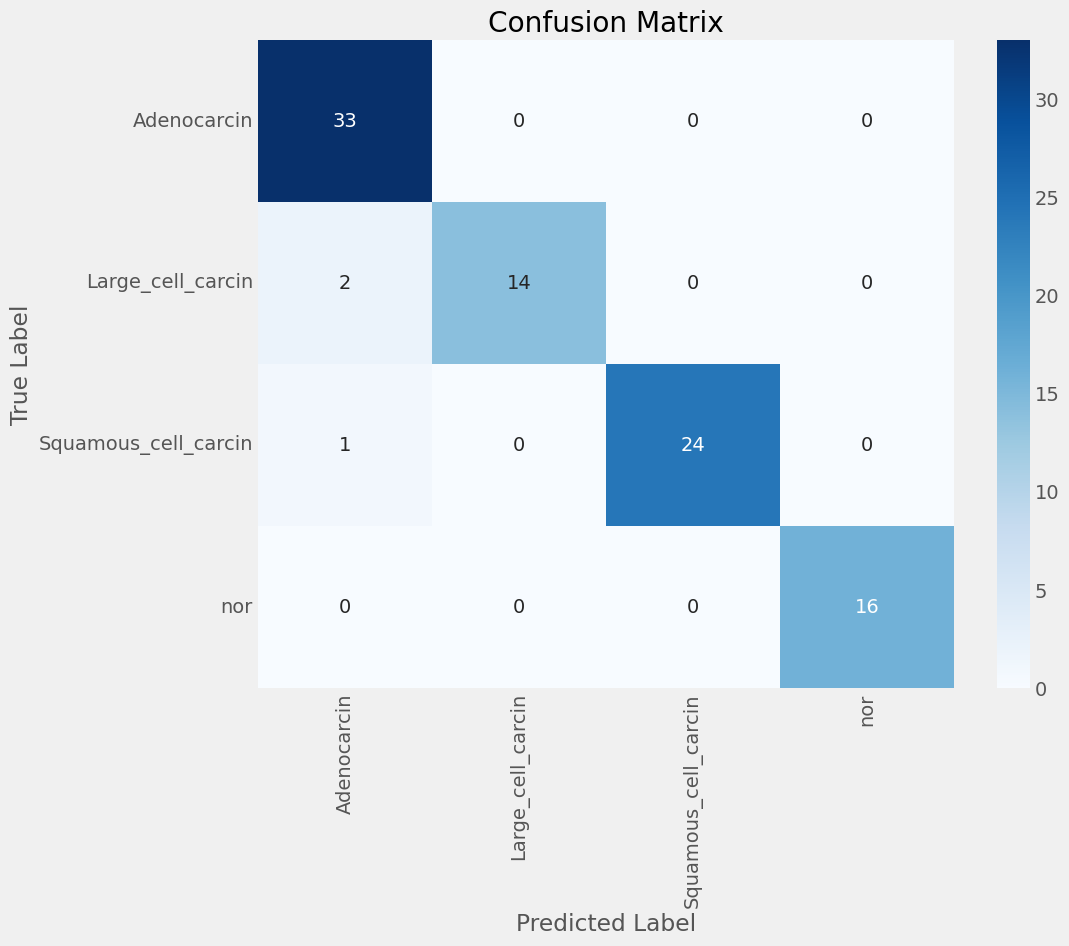

In [ ]:
class_names = list(test_gen.class_indices.keys())

confusion_mtx = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, cmap="Blues", annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
report = classification_report(y_true_labels, y_pred_labels, target_names=class_names)

print("Classification Report: ")
print(report)

Classification Report: 
                      precision    recall  f1-score   support

         Adenocarcin       0.92      1.00      0.96        33
   Large_cell_carcin       1.00      0.88      0.93        16
Squamous_cell_carcin       1.00      0.96      0.98        25
                 nor       1.00      1.00      1.00        16

            accuracy                           0.97        90
           macro avg       0.98      0.96      0.97        90
        weighted avg       0.97      0.97      0.97        90

